In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\dinar\AppData\Local\Temp\ipykernel_9928\765240082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [3]:
def iterate(data, idx, step=10, low=False):
    # change step size if we have smaller input data
    step = 50 if low else 100

    # select starting point depending on the size of the input data
    start = idx * step if idx > 0 else 0

    # select ending point (if smaller, 300 days rolling window. Otherwise, 600)
    if low:
        end = 300 + step * idx
    else:
        end = 600 + step * idx

    train, val = data.iloc[start: start + end - 30, :], data.iloc[start + end - 30: start + end, :]
    return train, val


def custom_pnl_10(y_pred, y_true):
    nth = 10

    thresh = 0.2
    try:
        diff = y_pred[nth - 1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl



In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

class TargetFeature:
    def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
                 features=None, **kwargs):
        self.results_path = results_path

        self.data = data
        self.test_start = test_start
        self.test_end = test_end
        self.target = target
        self.features = features

        # define pd.DataFrame to store resulting df
        self.target_and_feature = None

        # define scaler
        self.scaler = MinMaxScaler()

        # define a starting message for log
        self.message = 'Task 2 [TargetFeature]:\n\t'

    def __call__(self, *args, **kwargs):
        self._setup()

    def _setup(self):
        # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')
        target = self.data[self.target]
        target.interpolate(inplace=True)
        target.dropna(inplace=True)
        
        self.target_and_feature = pd.DataFrame(index=self.data.index)
        self.target_and_feature['actual_target'] = target
        self.target_and_feature['predicted_target'] = target
        
        if self.features is not None:            
            decompose = seasonal_decompose(target, model='additive', period=4)
            
            for feature in self.features:
                if feature in ['rolling', 'all']:
                    rolling = self.data[self.target].rolling(5).mean()
                    self.target_and_feature['actual_rolling'] = rolling[:self.test_end]
                    self.target_and_feature['predicted_rolling'] = rolling[:self.test_start]
                if feature in ['seasonality', 'all']:
                    self.target_and_feature['actual_seasonality'] = decompose.seasonal
                if feature in ['fft', 'all']:
                    fft_value = np.fft.fft(target)
                    self.target_and_feature['actual_fft_real'] = fft_value.real
                    self.target_and_feature['predicted_fft_real'] = self.target_and_feature['actual_fft_real'][:self.test_start]
                    self.target_and_feature['actual_fft_imag'] = fft_value.imag
                    self.target_and_feature['predicted_fft_imag'] = self.target_and_feature['actual_fft_imag'][:self.test_start]
                if feature in ['diff', 'all']:
                    self.target_and_feature['actual_diff'] = target.diff()
                    self.target_and_feature['predicted_diff'] = self.target_and_feature['actual_diff'][:self.test_start]
                if feature in ['seasonal_diff', 'all']:
                    self.target_and_feature['actual_seasonal_diff'] = decompose.seasonal.diff()
                if feature in ['ewm', 'all']:
                    self.target_and_feature['actual_ewm'] = target.ewm(span=30, adjust=True).mean()
                    self.target_and_feature['predicted_ewm'] = self.target_and_feature['actual_ewm'][:self.test_start]
            
            # self.target_and_feature.dropna(inplace=True)

            # fit a scaler
            columns = [x for x in self.target_and_feature if 'predicted' not in x and 'target' not in x]
            self.scaler.fit(self.target_and_feature[columns])


    def get_target_feature(self, end_date, start_date=None, include_past=False):
        # return all values until specified date
        if include_past:
            if start_date is not None:
                # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
                return self.target_and_feature.loc[start_date:end_date, :]
            # self.log(self.log_path, f'Returning all dates until {end_date}')
            return self.target_and_feature.loc[:end_date, :]

        # return one-day results
        try:
            entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
        except KeyError:
            # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
            raise KeyError(f'{self.message}Date {end_date} does not exist!')
        else:
            # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
            return entry

    def set_target_feature(self, date, column, value):
        fmt = '%Y-%m-%d'

        # raise error if the supplemented date is less than the test start
        # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
        #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
        #     self.log(self.log_path, self.message + message, CRITICAL)
        #     raise Exception(message)
        
        # with open('track.txt', 'a') as fout:
        #     fout.writelines(f'{date} - {column}: {value}\n')

        # get previous value
        previous = self.target_and_feature.loc[date, column]

        # log information
        # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

        # set new value
        self.target_and_feature.loc[date, column] = value

        # save current state
        # self.target_and_feature.reset_index(inplace=True)
        self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
        # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [5]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None, feat_importance='total_gain'):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if target_col in columns:
        columns = list(columns)
        columns.remove(target_col)
        
    if len(columns) > 1:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm']
        all_pred_target_cols = ['predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe={"_".join(target_features)}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe=False.model'
    
    # start pretraining the model
    window_size = 10
    for idx in range(len(train) - 400, len(train) - window_size + 1, window_size):
        # get batches
        train_temp = train.iloc[idx:idx+window_size]
        
        # get rolling and target columns
        if use_features:
            train_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])

        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(test, target_feature.get_target_feature(end_date=test.index.max(), start_date=test.index.min(), include_past=True)[target].values)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(test, target_feature.get_target_feature(end_date=test.index.max(), start_date=test.index.min(), include_past=True)[target].values)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        full_train[[target_col] + current_target_cols] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                           include_past=True)[[target] + current_target_cols].values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_features:
        # normalize data
        full_train[current_target_cols] = target_feature.scaler.transform(full_train[current_target_cols])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, model_name
    
    return model, train, test, scaler, target_feature, model_name

def get_columns(columns_selection, model, feat_eng_thresh=30, feat_importance='total_gain'):
    if columns_selection == 'xgboost':
        scores = model.get_booster().get_score(importance_type=feat_importance)
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] >= feat_eng_thresh]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, 
                    n_estimators=1500, target_features=None, use_fe=False, feat_eng_thresh=30, feat_importance='total_gain'):
    if use_fe:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None,
                                                                 feat_importance='total_gain')

        columns = get_columns(columns_selection, model, feat_eng_thresh, feat_importance=feat_importance)
        columns = [x for x in columns if not x.startswith('rolling')]
        
        print('Removing temporary model:', model_name)
        os.remove(model_name)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                use_features=use_features, n_estimators=n_estimators, 
                                                                                                target_features=target_features, feat_importance=feat_importance)
    else:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                            model_suffix='partial', columns=columns, path=results_folder, 
                                                                            use_features=use_features, n_estimators=n_estimators, 
                                                                            target_features=target_features, feat_importance=feat_importance)
    
    print('============')
    print(f'Use target features: {use_features} [{target_features}]')
    print(f'Use feature engineering for column selection: {use_fe} [type={feat_importance} >= {feat_eng_thresh}]')
    print('Model is stored in:', model_name)
    print('Number of columns:', len(columns))
    print('Columns:', columns, end='\n============\n')
    
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()
    
    t1_to_10_values = market_data[market_data.index >= test_start].iloc[0, -10:]

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None
            
            t1_to_10_values = list(sliding_history.iloc[-1, -10:].values)

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:                    
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]
                    
                    print('Testx columns:', columns)
                    
                    if counter2 == 0:
                        t1_to_10_values = list(testx.iloc[0, -10:])
                        print('Original values at index 0 are not touched:', t1_to_10_values)
                    else:
                        print(f'Index at {counter2} is changed to: {t1_to_10_values}')
                    
                    # cols = [f't-{x}' for x in range(1, 10)]
                    # print('Columns to change:', testx.iloc[0, -10:].columns)
                    
                    testx.iloc[0, -10:] = t1_to_10_values

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_features:
                        decompose = seasonal_decompose(current_targets, model='additive', period=4)
                        fft_value = np.fft.fft(current_targets)
                        
                        features = pd.DataFrame(index=current_targets.index)
                        
                        for feature in current_target_cols:                            
                            if feature == 'actual_rolling':
                                method = current_targets.rolling(5).mean()
                            if feature == 'actual_ewm':
                                method = current_targets.ewm(span=30, adjust=True).mean()
                            if feature == 'actual_trend':
                                method = decompose.trend
                            if feature == 'actual_seasonality':
                                method = current_values['actual_seasonality']
                            if feature == 'actual_fft_imag':
                                method = fft_value.imag 
                            if feature == 'actual_fft_real':
                                method = fft_value.real
                            if feature == 'actual_diff':
                                method = current_targets.diff()
                            if feature == 'actual_seasonal_diff':
                                method = decompose.seasonal.diff()
                            
                            features[feature] = method
                        
                        try:
                            features = pd.DataFrame(target_feature.scaler.transform(features), index=features.index, columns=features.columns)
                            features = features.loc[:sliding_start_date]
                        except ValueError:
                            pass
                        
                        for col in features.columns:
                            testx[col] = features.loc[sliding_start_date, col]

                    # get predictions
                    prediction = model.predict(testx)
                    
                    # append to t-1 place
                    t1_to_10_values.insert(0, prediction)
                    t1_to_10_values.pop()
                    
                    # substitute values for the next iteration

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_features:
                        inverse = target_feature.scaler.inverse_transform(testx[current_target_cols])
                        
                        for idx, feature in enumerate(current_target_cols):
                            target_feature.set_target_feature(str(sliding_start_date)[:10], feature, inverse[0][idx])

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
                print('\n=====\n')
               
                    
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'target_features': target_features, 'model_name': model_name, 'columns': columns,
            'scaler': scaler}

In [6]:
def target_manipulations(data, target):
    shifted = pd.DataFrame(columns=[f't{x}' for x in range(-1, -11, -1)], index=data.index)
    shifted = shifted[::-1]                           # reverse the dataframe
    
    reversed_data = data.reset_index()[::-1]          # reverse the original df
    
    for i, (idx, row) in enumerate(reversed_data[[target]].iterrows()):
        vals = []
        
        for ix in range(1, 11):
            try:
                ixs = idx - ix
                
                if ixs < 0:
                    vals.append(np.nan)
                else:
                    val = reversed_data.iloc[-ixs - 1][target]
                    vals.append(val)
                print('ix:', ix, 'idx:', idx, 'i:', i, 'ixs:', ixs)
            except IndexError:
                vals.append(np.nan)
            except ZeroDivisionError:
                vals.append(np.nan)
        
        shifted.iloc[i, :] = vals
    
    # reverse back, merge, and remove the first values
    shifted = shifted.reset_index()[::-1]
    shifted = shifted.merge(data[target], on='pricing_date')
    shifted = shifted.iloc[20:, :]
    shifted.drop(columns=target, inplace=True)
    
    # shifted = shifted[shifted.columns[::-1]]
    
    return shifted
    
    

def get_data(path, test_start, test_end, target='F380 M2/M3'):
    data = pd.read_csv(path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    data.interpolate('linear', inplace=True)
    
    # slice the dataset
    data = data[data.index < test_end]
    
    data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
    data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
    data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
    data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


    data['year_num'] = data.index.year
    data['month_num'] = data.index.month
    data['day_num'] = data.index.day
    data['dow_num'] = data.index.dayofweek
    
    # get t-1, ..., t-10
    lags = target_manipulations(data, target)
    
    return data, lags
    

In [7]:
data, lags = get_data('../data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')

ix: 1 idx: 1818 i: 0 ixs: 1817
ix: 2 idx: 1818 i: 0 ixs: 1816
ix: 3 idx: 1818 i: 0 ixs: 1815
ix: 4 idx: 1818 i: 0 ixs: 1814
ix: 5 idx: 1818 i: 0 ixs: 1813
ix: 6 idx: 1818 i: 0 ixs: 1812
ix: 7 idx: 1818 i: 0 ixs: 1811
ix: 8 idx: 1818 i: 0 ixs: 1810
ix: 9 idx: 1818 i: 0 ixs: 1809
ix: 10 idx: 1818 i: 0 ixs: 1808
ix: 1 idx: 1817 i: 1 ixs: 1816
ix: 2 idx: 1817 i: 1 ixs: 1815
ix: 3 idx: 1817 i: 1 ixs: 1814
ix: 4 idx: 1817 i: 1 ixs: 1813
ix: 5 idx: 1817 i: 1 ixs: 1812
ix: 6 idx: 1817 i: 1 ixs: 1811
ix: 7 idx: 1817 i: 1 ixs: 1810
ix: 8 idx: 1817 i: 1 ixs: 1809
ix: 9 idx: 1817 i: 1 ixs: 1808
ix: 10 idx: 1817 i: 1 ixs: 1807
ix: 1 idx: 1816 i: 2 ixs: 1815
ix: 2 idx: 1816 i: 2 ixs: 1814
ix: 3 idx: 1816 i: 2 ixs: 1813
ix: 4 idx: 1816 i: 2 ixs: 1812
ix: 5 idx: 1816 i: 2 ixs: 1811
ix: 6 idx: 1816 i: 2 ixs: 1810
ix: 7 idx: 1816 i: 2 ixs: 1809
ix: 8 idx: 1816 i: 2 ixs: 1808
ix: 9 idx: 1816 i: 2 ixs: 1807
ix: 10 idx: 1816 i: 2 ixs: 1806
ix: 1 idx: 1815 i: 3 ixs: 1814
ix: 2 idx: 1815 i: 3 ixs: 1813
ix: 3

In [8]:
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2017-01-10       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-11       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-12       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-13       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-16       0.0       0.0       0.0        0.0   0.0  0.000000   
...              ...       ...       ...        ...   ...       ...   
2023-12-25       0.0       0.0       0.0        0.0   0.0  2.300491   
2023-12-26       0.0       0.0       0.0        0.0   0.0  2.404817   
2023-12-27       0.0       0.0       0.0        0.0   0.0  2.791667   
2023-12-28       0.0       0.0       0.0        0.0   0.0  2.700562   
2023-12-29       0.0       0.0       0.0        0.0   0.0  2.847652   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...  _rgp_11_sz_3  \
pricing_date                                      ...                 
2017-01-10            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-11            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-12            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-13            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-16            0.0     0.0     0.0    0.0  ...           0.0   
...                   ...     ...     ...    ...  ...           ...   
2023-12-25            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-26            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-27            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-28            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-29            0.0     0.0     0.0    0.0  ...           0.0   

              F380 M2/M3      year_sin     month_sin   day_sin       dow_sin  \
pricing_date                                                                   
2017-01-10         1.500 -1.863417e-02  5.000000e-01  0.897805  1.000000e+00   
2017-01-11         1.300 -1.863417e-02  5.000000e-01  0.790776  1.224647e-16   
2017-01-12         1.700 -1.863417e-02  5.000000e-01  0.651372 -1.000000e+00   
2017-01-13         1.850 -1.863417e-02  5.000000e-01  0.485302 -2.449294e-16   
2017-01-16         2.000 -1.863417e-02  5.000000e-01 -0.101168  0.000000e+00   
...                  ...           ...           ...       ...           ...   
2023-12-25         3.225 -2.449294e-16 -2.449294e-16 -0.937752  0.000000e+00   
2023-12-26         2.950 -2.449294e-16 -2.449294e-16 -0.848644  1.000000e+00   
2023-12-27         3.150 -2.449294e-16 -2.449294e-16 -0.724793  1.224647e-16   
2023-12-28         3.450 -2.449294e-16 -2.449294e-16 -0.571268 -1.000000e+00   
2023-12-29         3.550 -2.449294e-16 -2.449294e-16 -0.394356 -2.449294e-16   

              year_num  month_num  day_num  dow_num  
pricing_date                                         
2017-01-10        2017          1       10        1  
2017-01-11        2017          1       11        2  
2017-01-12        2017          1       12        3  
2017-01-13        2017          1       13        4  
2017-01-16        2017          1       16        0  
...                ...        ...      ...      ...  
2023-12-25        2023         12       25        0  
2023-12-26        2023         12       26        1  
2023-12-27        2023         12       27        2  
2023-12-28        2023         12       28        3  
2023-12-29        2023         12       29        4  

[1819 rows x 75 columns]

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [10]:
features = data.columns.tolist()[:66]
features

['ALVARI',
 'ARAMCOSG',
 'ARAMCOTF',
 'ARCENERGY',
 'BBEN',
 'BPSG',
 'BRIGHTOILSG',
 'BUYER1',
 'BUYER2',
 'CAOSG',
 'CARGILLSG',
 'CCMA',
 'CHEVRONSG',
 'COASTAL',
 'ENEOSSG',
 'ENOC',
 'FREEPTSG',
 'GLENCORESG',
 'GPGLOBALSG',
 'GULFSG',
 'GUNVORSG',
 'HL',
 'IDEMITSU',
 'ITGRES',
 'KAIROS',
 'KOCHRI',
 'LUKOIL',
 'MACQUARIESG',
 'MAERSKSG',
 'MERCURIARESOURCES',
 'MERCURIASG',
 'METS',
 'MIPCO',
 'P66SG',
 'PETCO',
 'PETROCHINA',
 'PETROSUMMIT',
 'PTT',
 'REPSOLSG',
 'REXCOMM',
 'RGES',
 'SELLER1',
 'SIETCO',
 'SINOHKPET',
 'SINOPECFO',
 'SINOPECHKSG',
 'SKEISG',
 'SOCAR',
 'SUMMITENERGY',
 'TOTALSG',
 'TRAFI',
 'UNIPECSG',
 'VITOLSG',
 'WANXIANG',
 'ZENROCK',
 '_rgp_01_sz_3',
 '_rgp_02_sz_3',
 '_rgp_03_sz_3',
 '_rgp_04_sz_3',
 '_rgp_05_sz_3',
 '_rgp_06_sz_3',
 '_rgp_07_sz_3',
 '_rgp_08_sz_3',
 '_rgp_09_sz_3',
 '_rgp_10_sz_3',
 '_rgp_11_sz_3']

In [12]:
lags.set_index('pricing_date', inplace=True)
lags

t-1    t-2    t-3    t-4   t-5    t-6    t-7    t-8    t-9  \
pricing_date                                                                 
2017-02-07     0.45    0.7  -0.45  -0.35 -0.75 -0.275    0.2   0.15   0.15   
2017-02-08     0.25   0.45    0.7  -0.45 -0.35  -0.75 -0.275    0.2   0.15   
2017-02-09      0.4   0.25   0.45    0.7 -0.45  -0.35  -0.75 -0.275    0.2   
2017-02-10      0.1    0.4   0.25   0.45   0.7  -0.45  -0.35  -0.75 -0.275   
2017-02-13     0.25    0.1    0.4   0.25  0.45    0.7  -0.45  -0.35  -0.75   
...             ...    ...    ...    ...   ...    ...    ...    ...    ...   
2023-12-25      3.5   2.85   2.75   2.75  2.75    2.0    2.5   2.25    2.3   
2023-12-26    3.225    3.5   2.85   2.75  2.75   2.75    2.0    2.5   2.25   
2023-12-27     2.95  3.225    3.5   2.85  2.75   2.75   2.75    2.0    2.5   
2023-12-28     3.15   2.95  3.225    3.5  2.85   2.75   2.75   2.75    2.0   
2023-12-29     3.45   3.15   2.95  3.225   3.5   2.85   2.75   2.75   2.75   

               t-10  
pricing_date         
2017-02-07      0.8  
2017-02-08     0.15  
2017-02-09     0.15  
2017-02-10      0.2  
2017-02-13   -0.275  
...             ...  
2023-12-25      2.5  
2023-12-26      2.3  
2023-12-27     2.25  
2023-12-28      2.5  
2023-12-29      2.0  

[1799 rows x 10 columns]

Frequency: 1D, Window: 3D, Drop: True


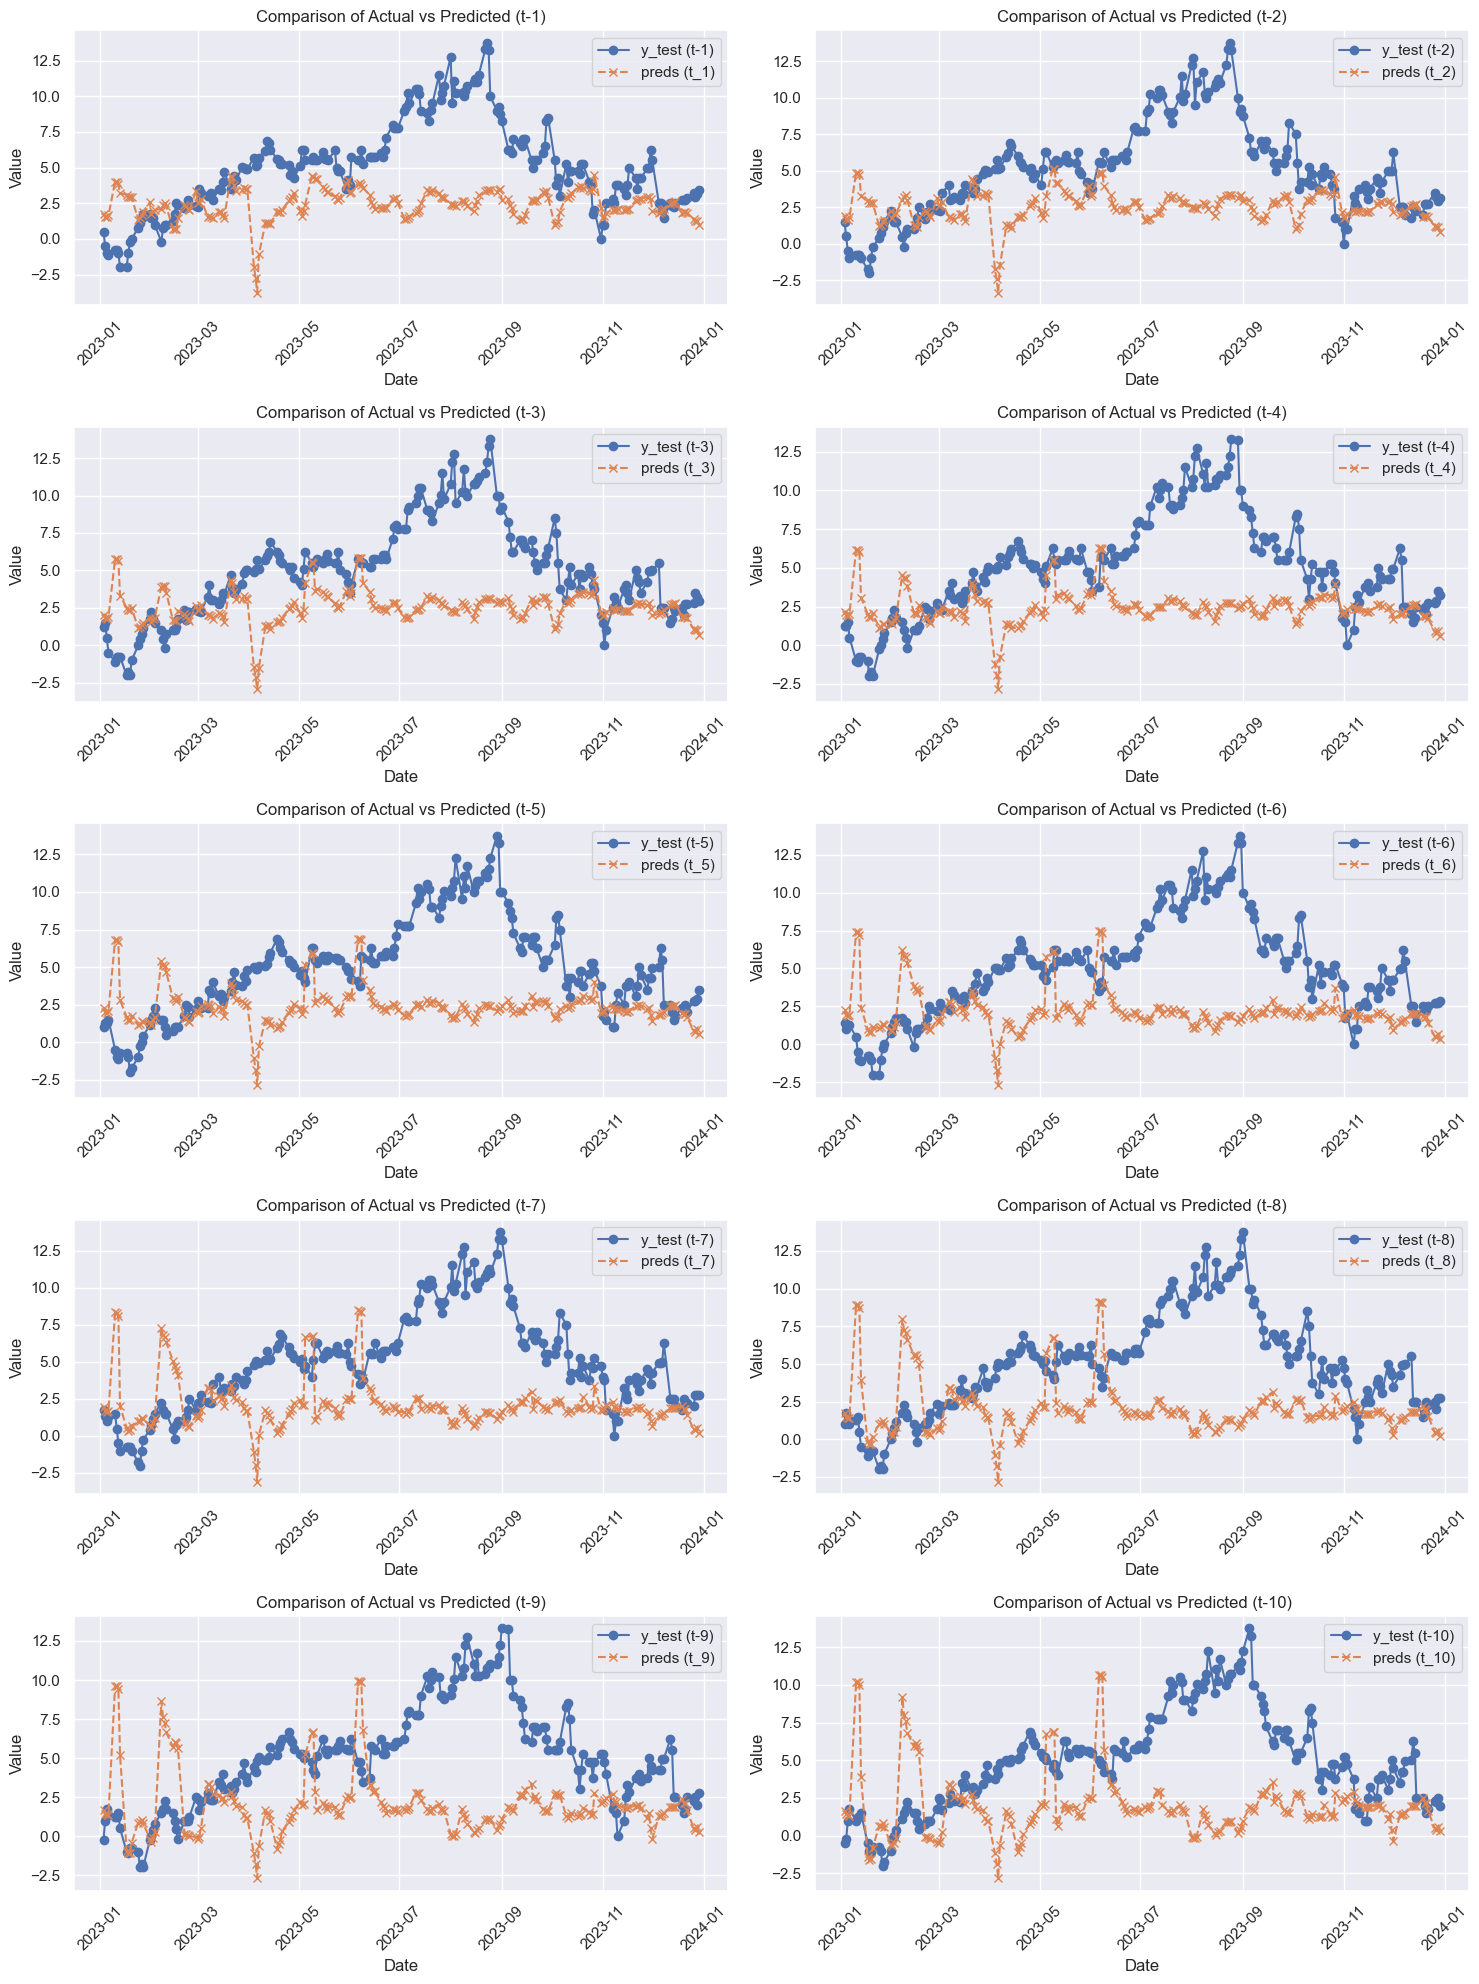



Frequency: 1D, Window: 3D, Drop: False


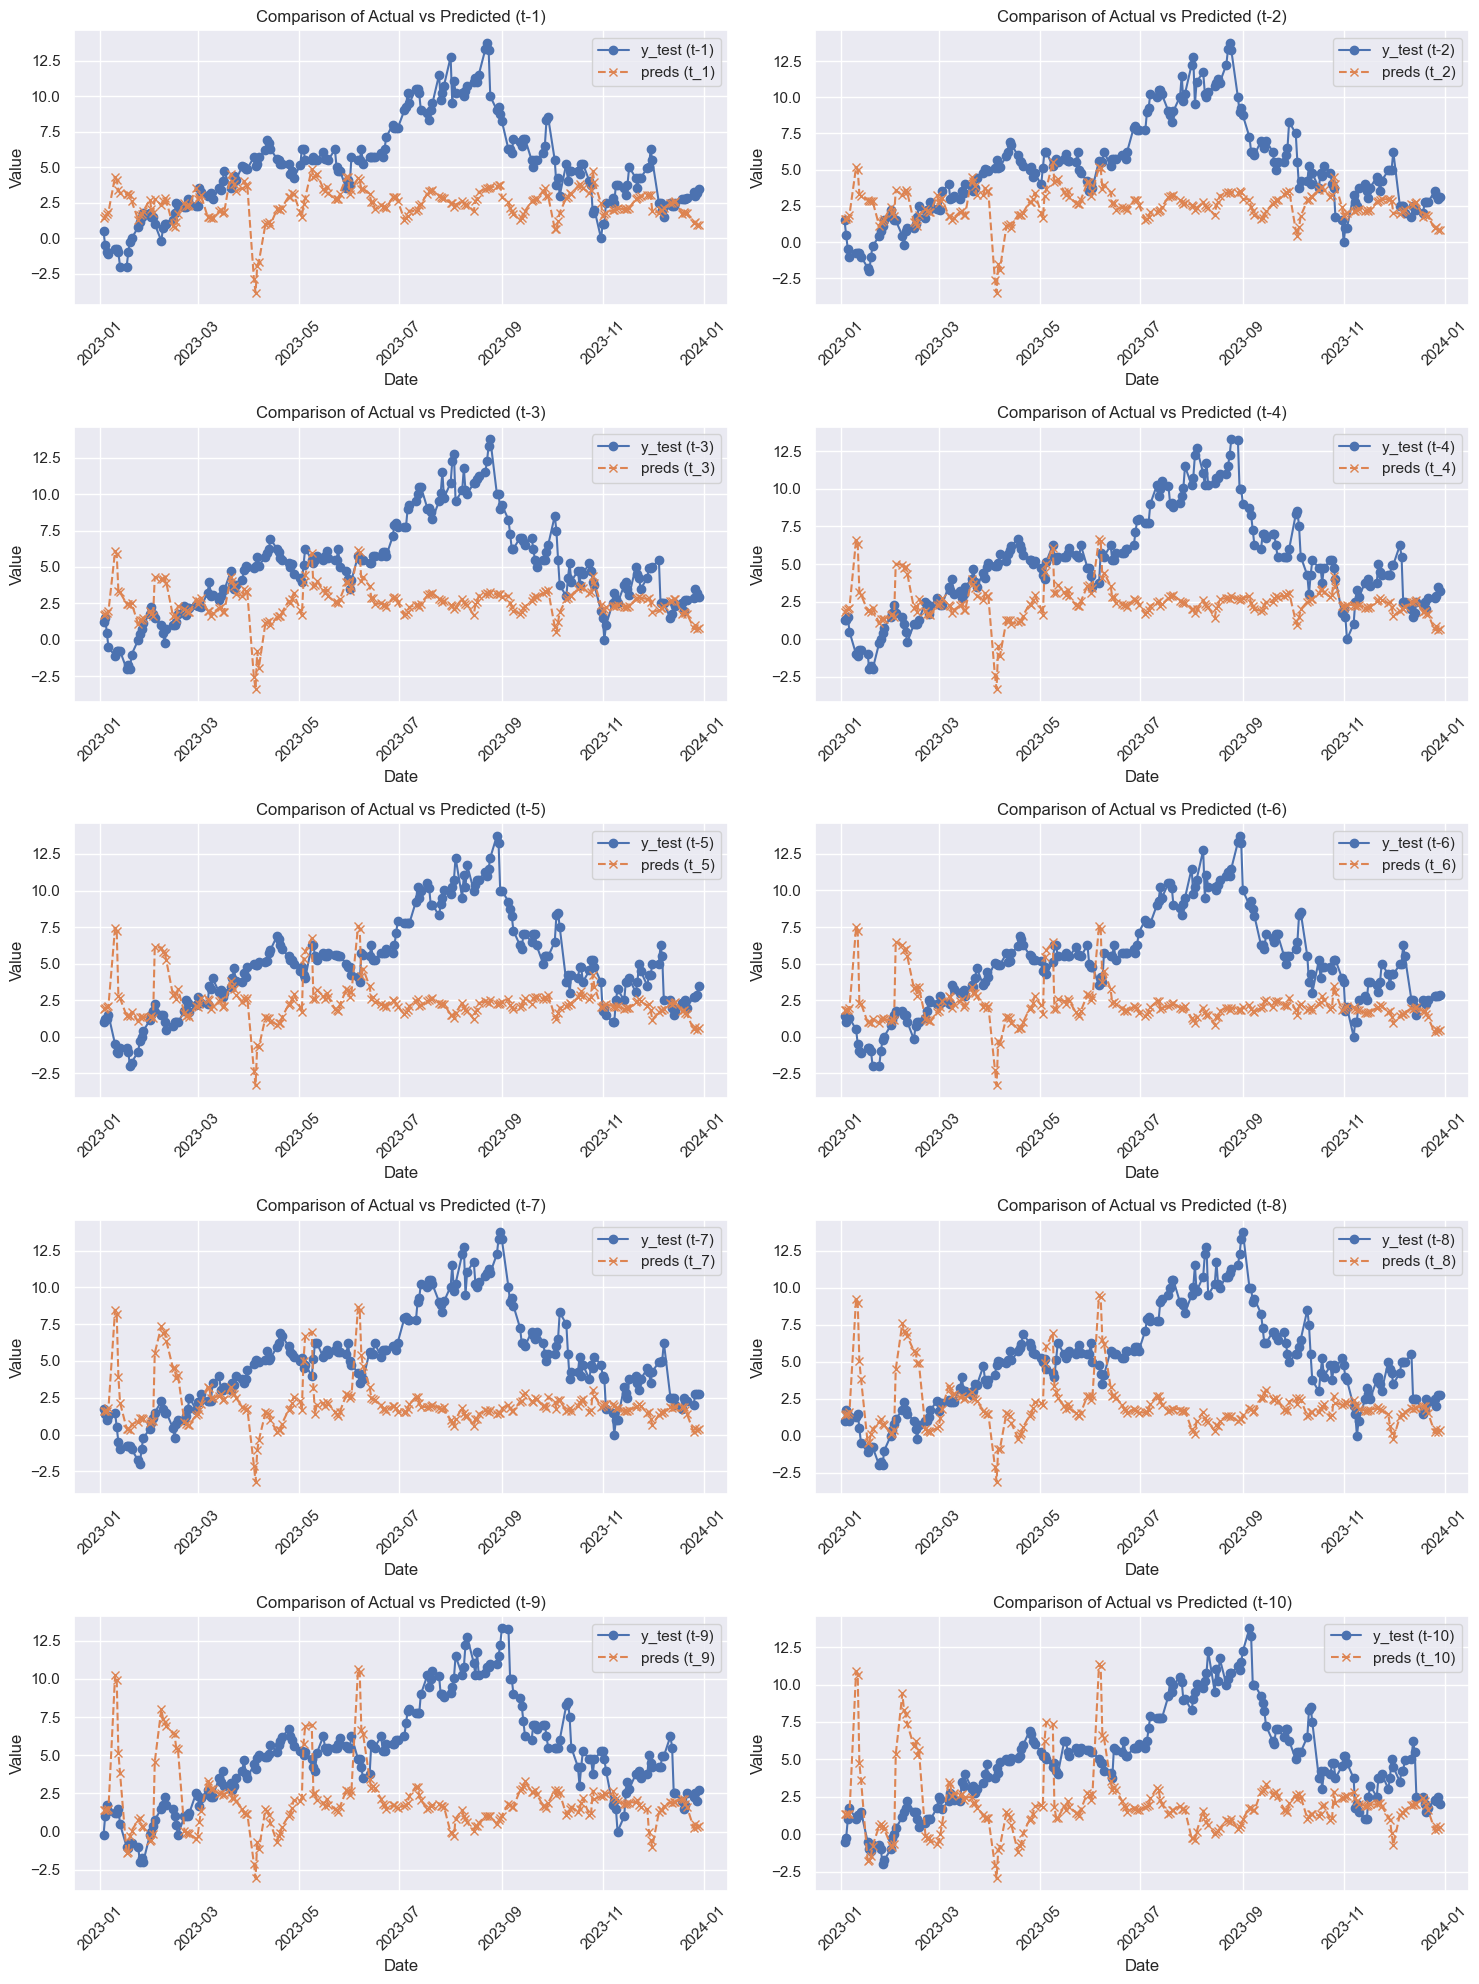



Frequency: 1D, Window: 5D, Drop: True


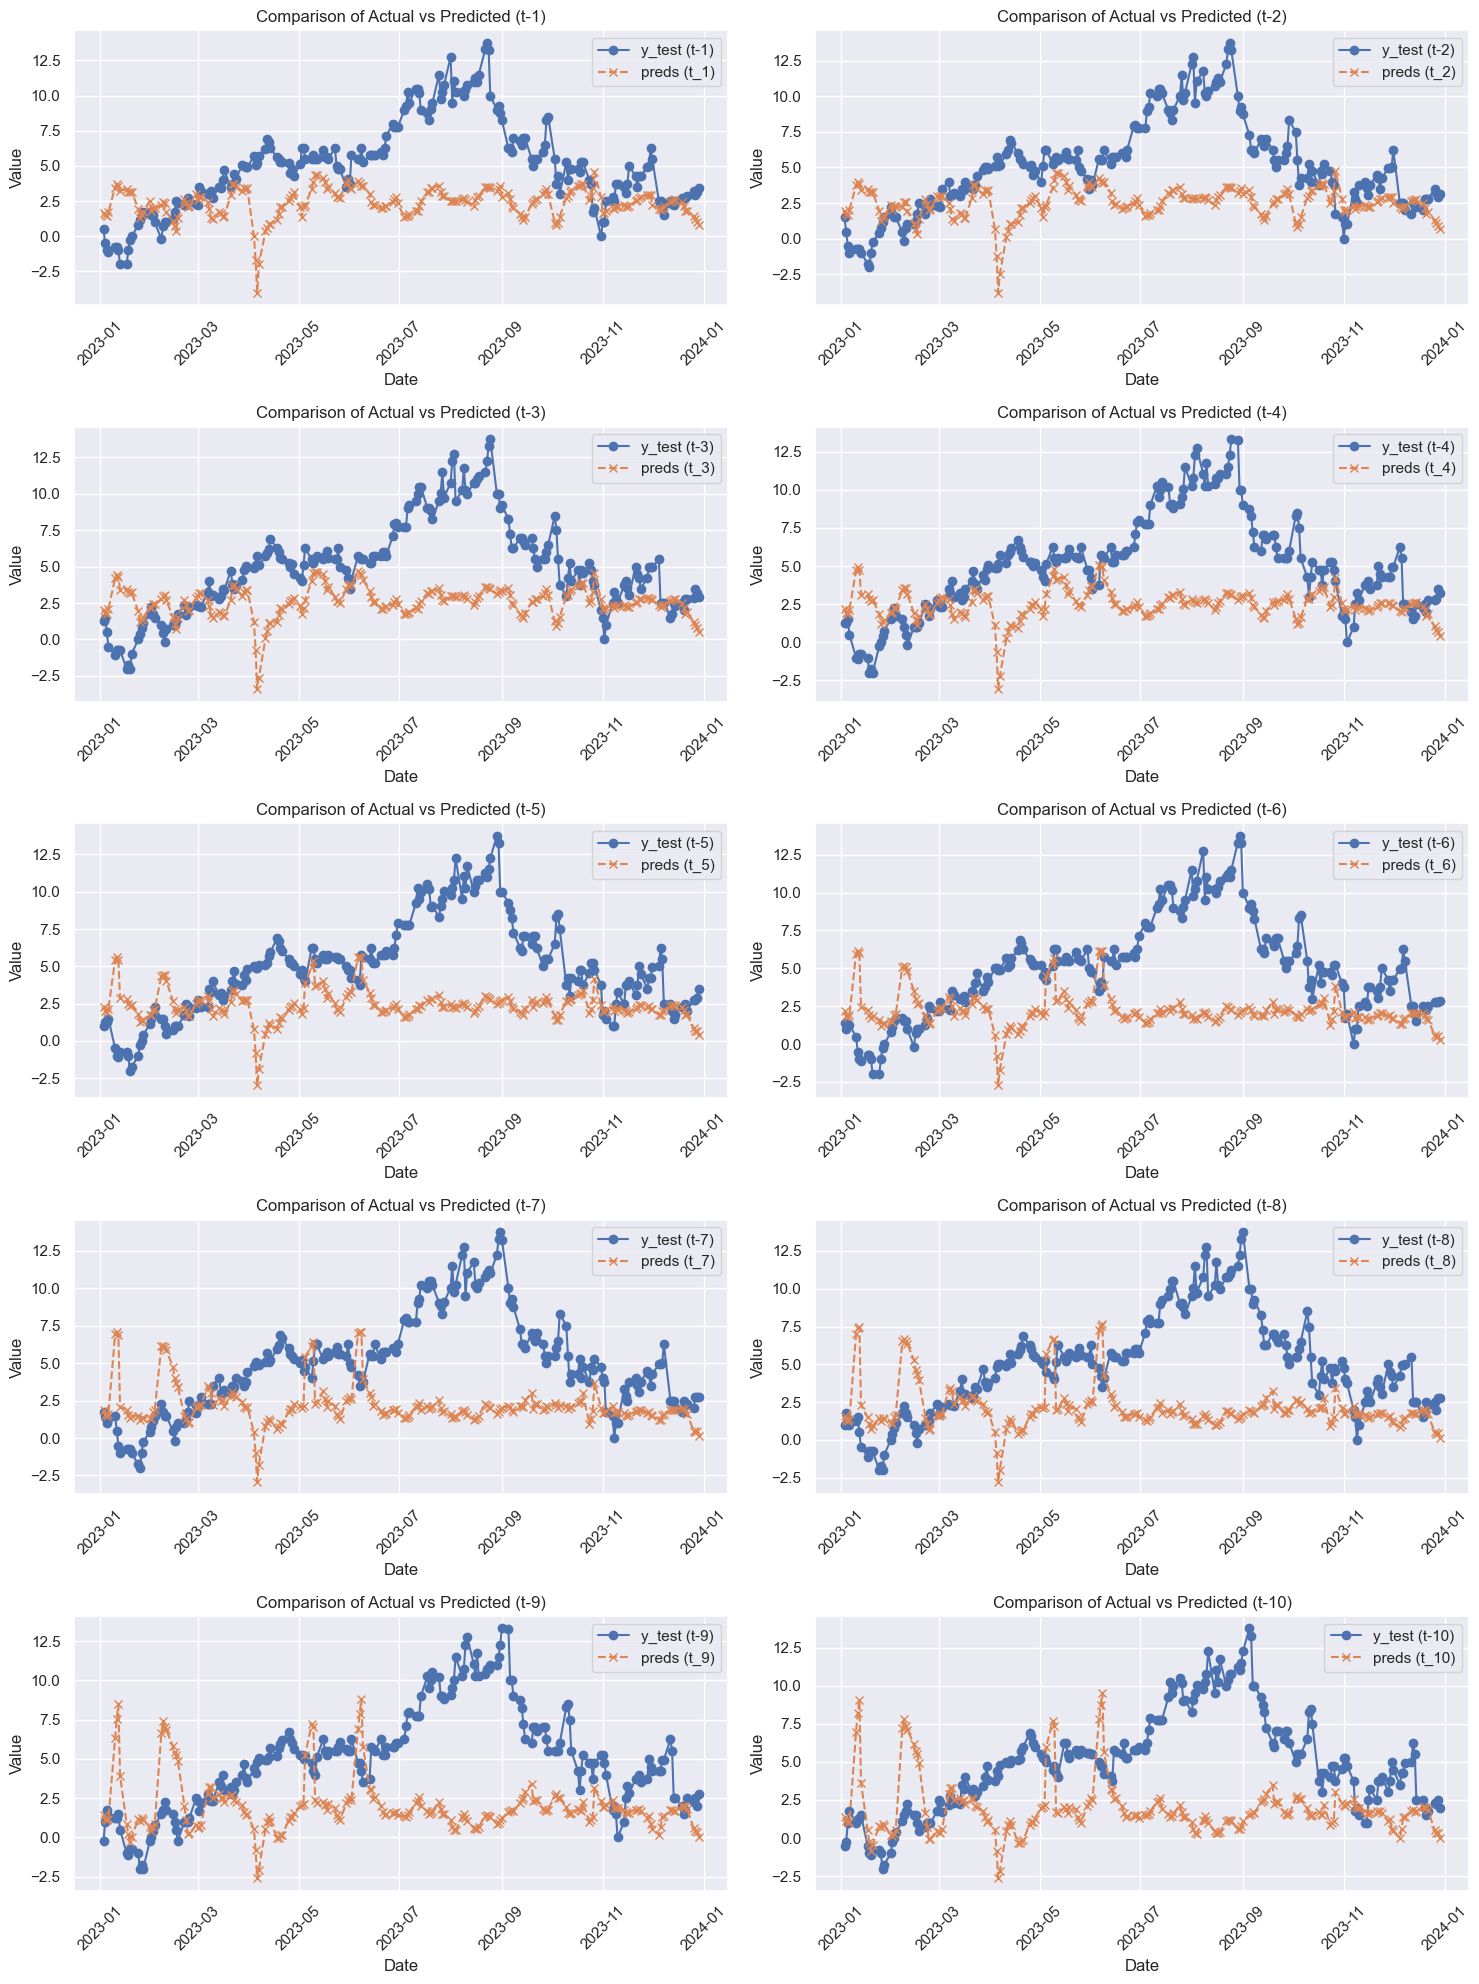



Frequency: 1D, Window: 5D, Drop: False


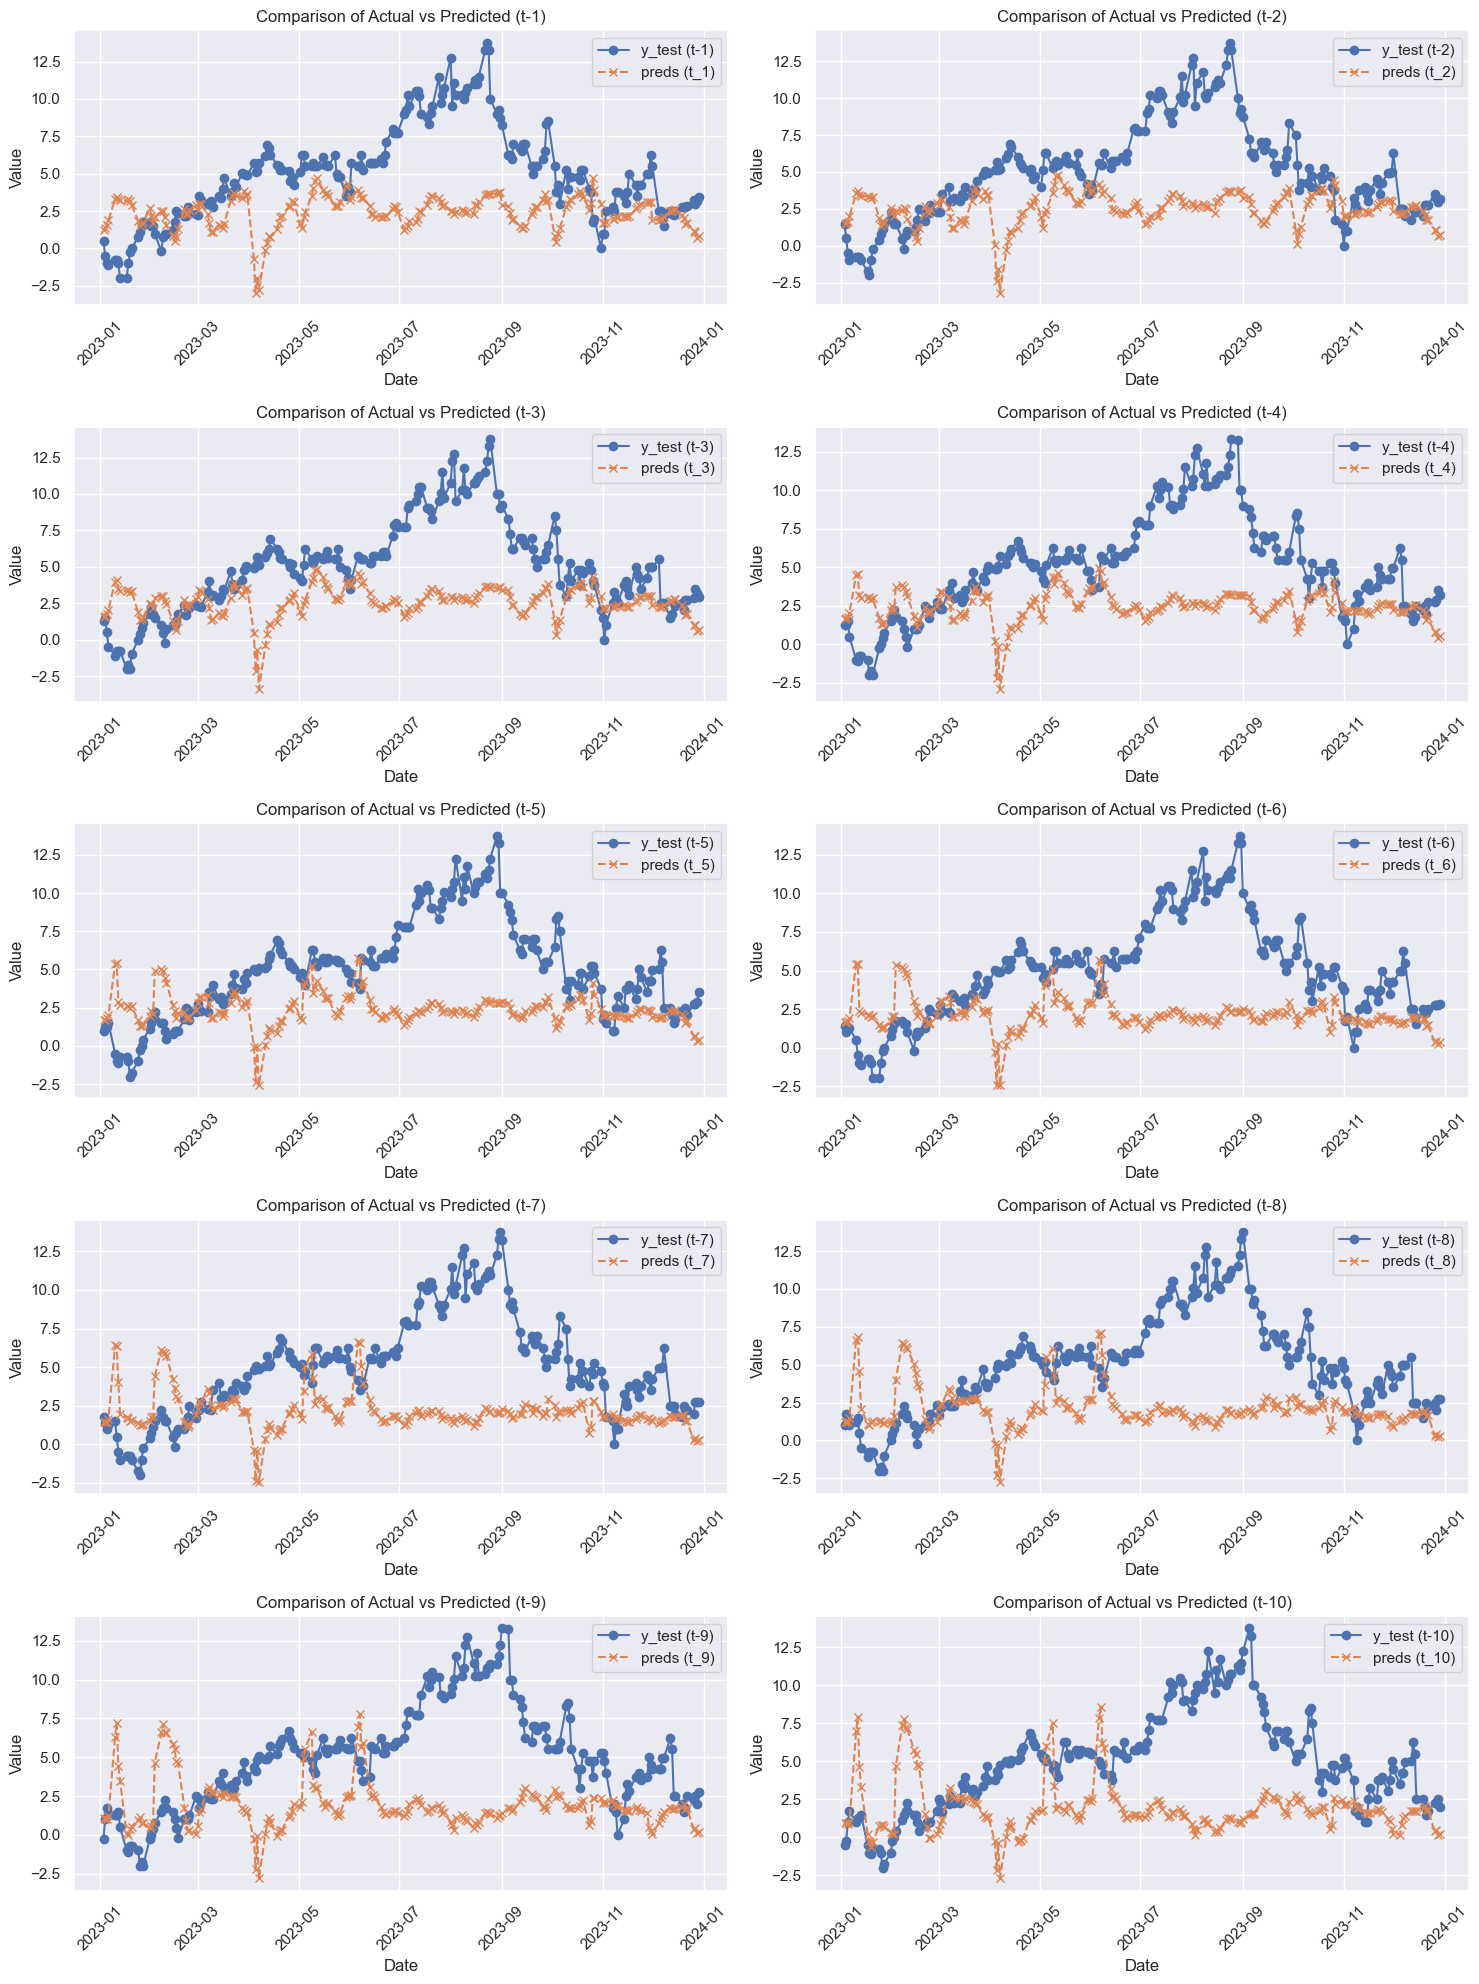



Frequency: 1D, Window: 10D, Drop: True


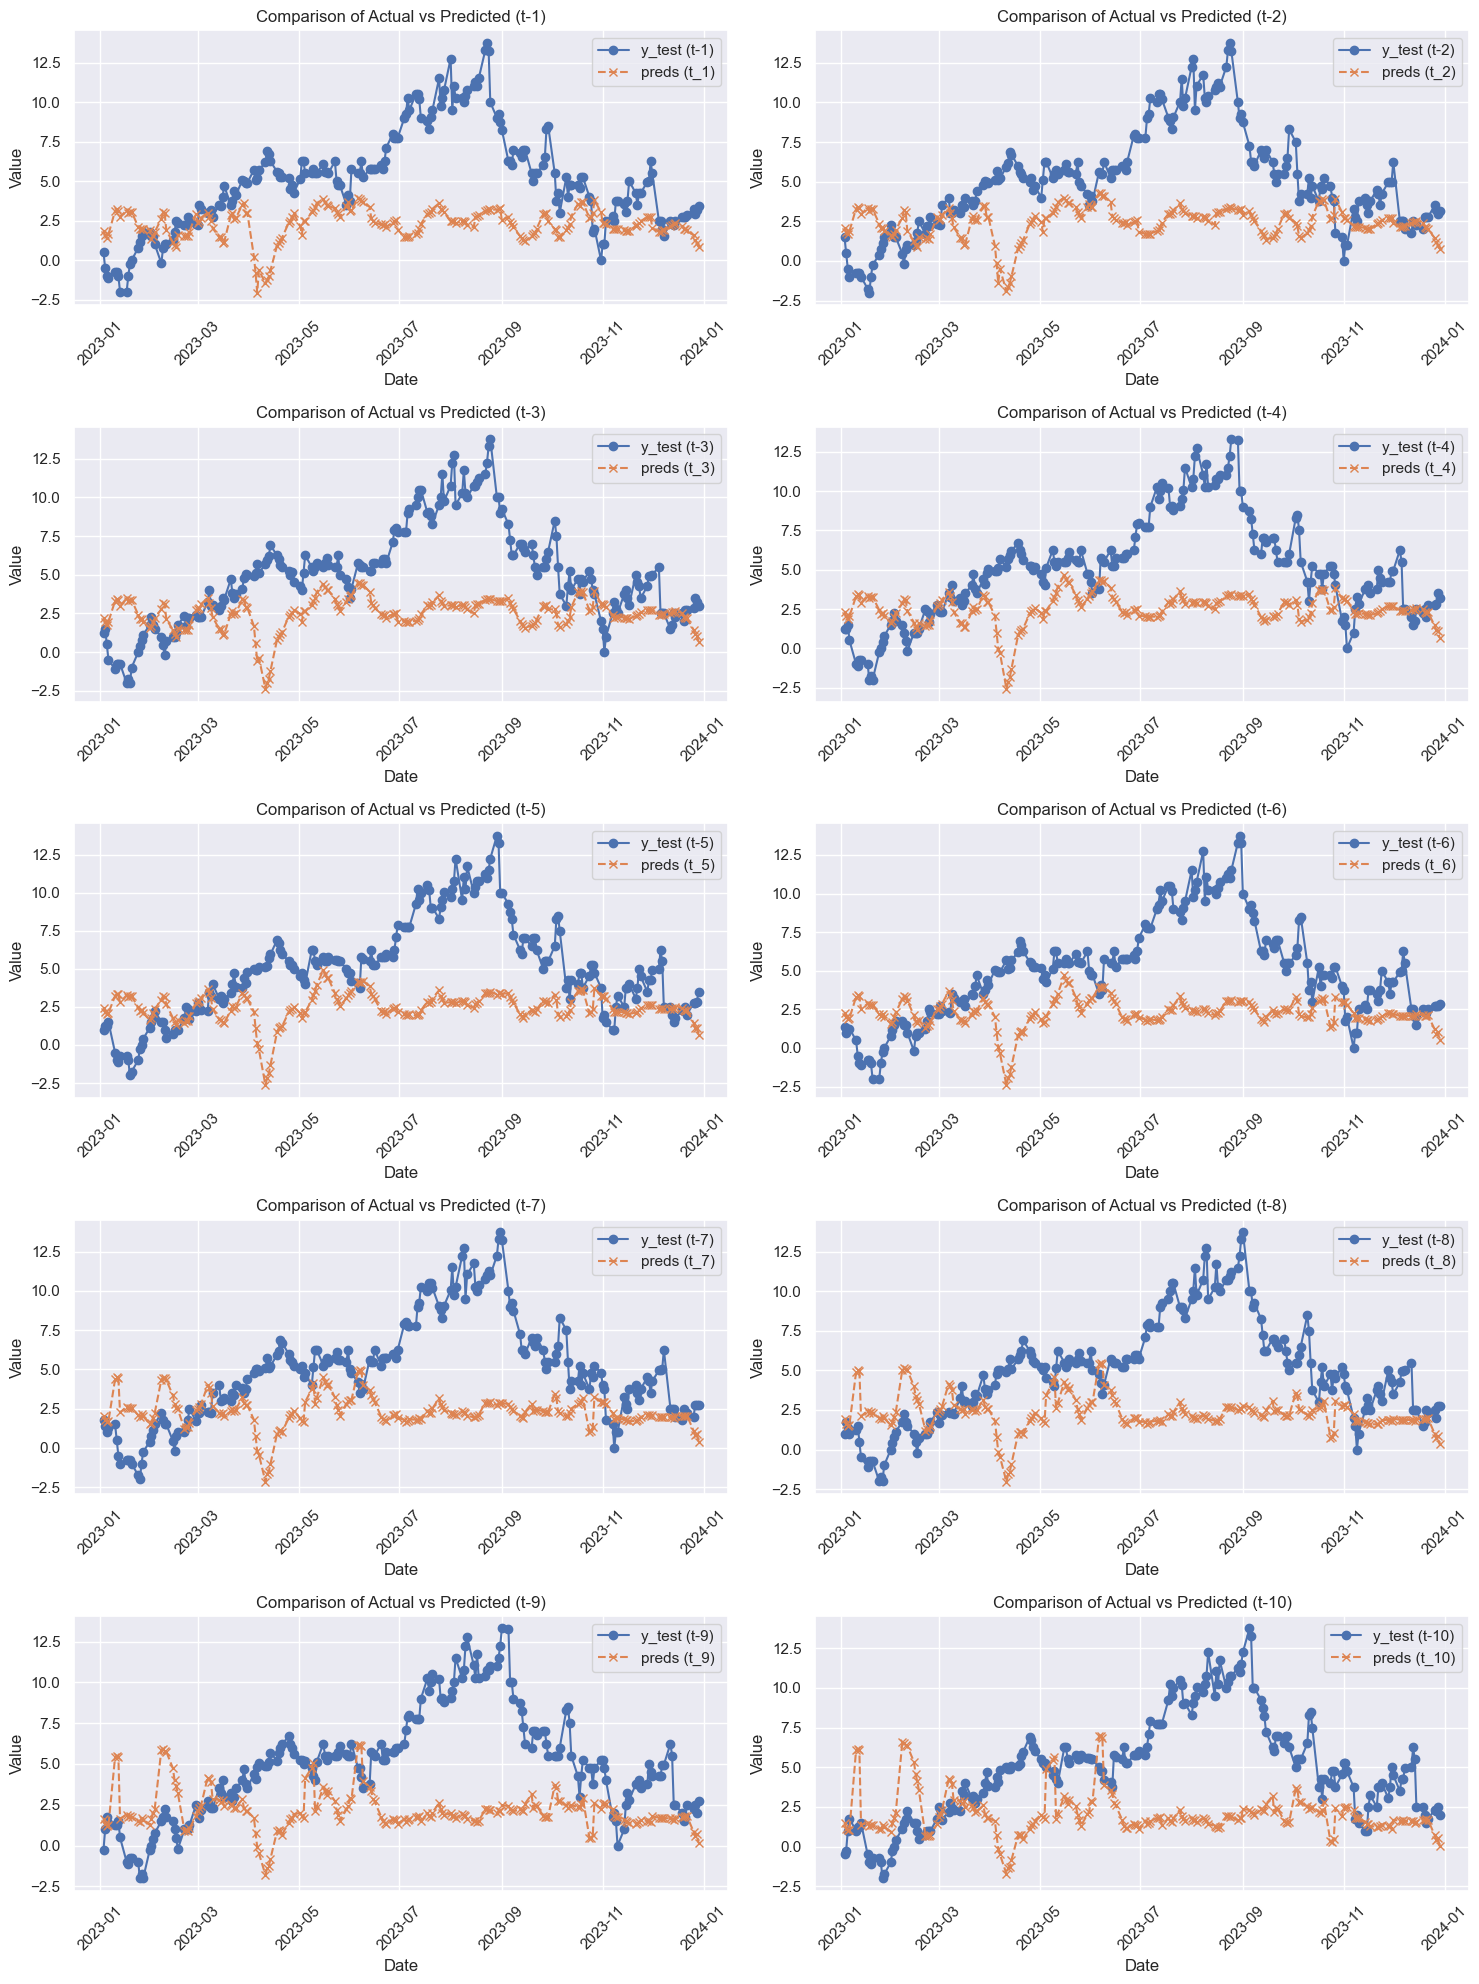



Frequency: 1D, Window: 10D, Drop: False


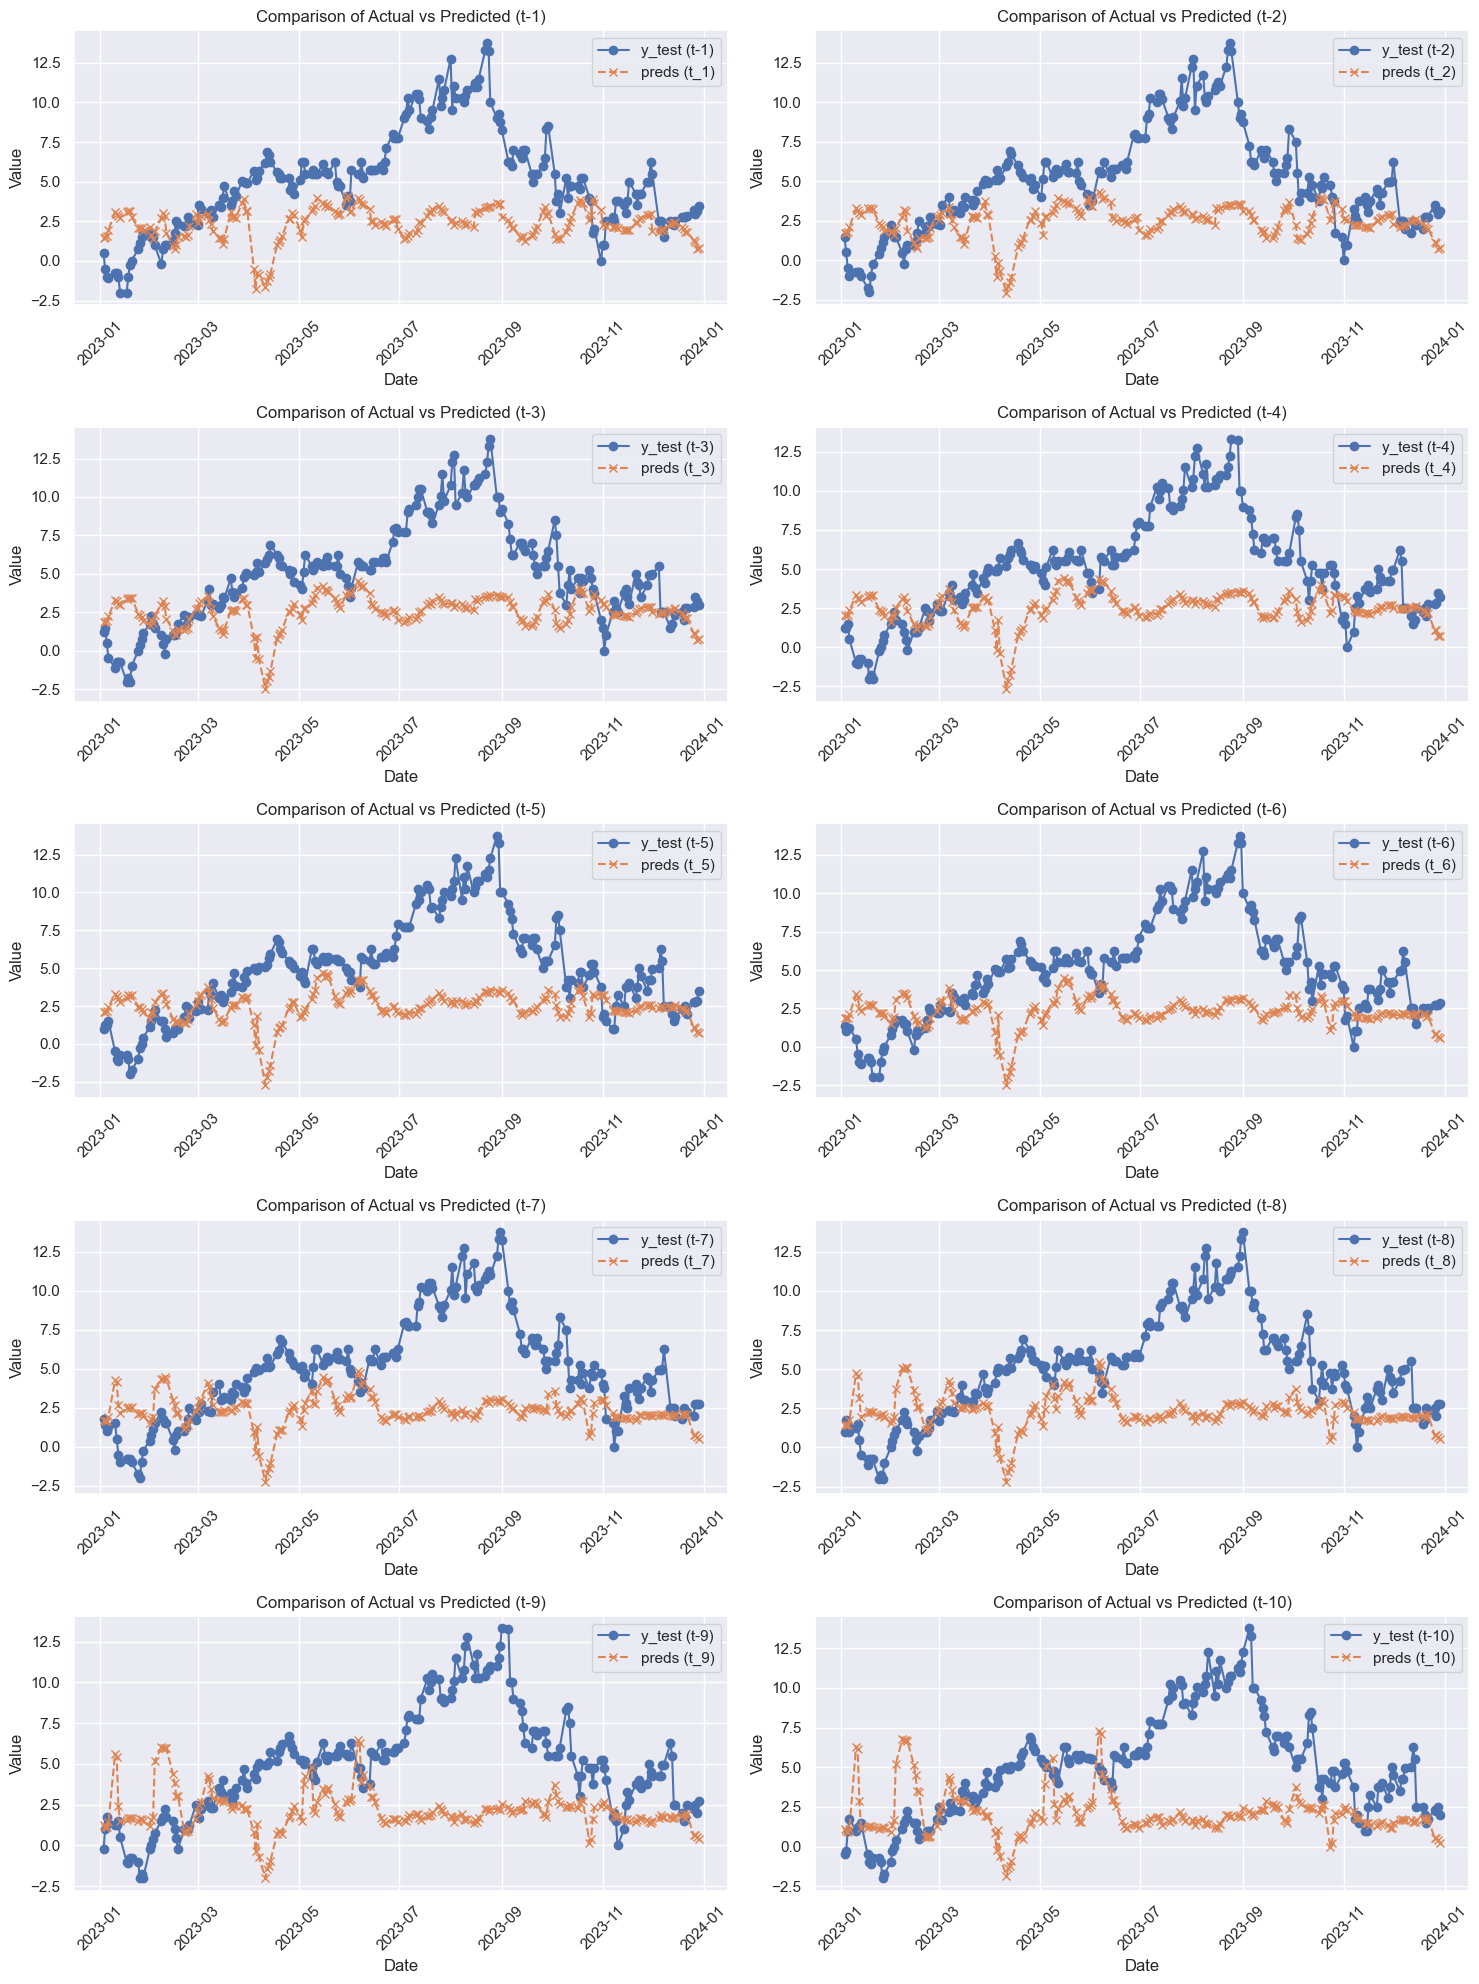



Frequency: ['1D', '5D'], Window: 3D, Drop: True


TypeError: unsupported operand type(s) for +: 'DatetimeArray' and 'list'

In [15]:
freq, window = ['1D', ['1D', '5D'], ['1D', '5D', '7D'], ['1D', '5D', '7D', '10D']], ['3D', '5D', '10D']

for f in freq:
    for w in window:
        for drop in [True, False]:
            
            print(f'Frequency: {f}, Window: {w}, Drop: {drop}')
            
            # date features
            dtf = DatetimeFeatures(
                variables='index',
                
                features_to_extract=[
                    'month', 'week', 'day_of_week', 'day_of_month'
                ]
            )

            # lag features
            lagf = LagFeatures(
                variables=features,
                freq=f,
                missing_values='ignore'
            )

            # window features
            winf = WindowFeatures(
                variables=features,
                window=w,
                freq=f,
                missing_values='ignore'
            )

            # periodic features
            cyclicf = CyclicalFeatures(
                variables=['month', 'week', 'day_of_week', 'day_of_month'],
                drop_original=False
            )

            imputer = DropMissingData()
            
            if drop:
                drop_ts = DropFeatures(features_to_drop=features)

                pipe = Pipeline([
                    ('datetime_features', dtf),
                    ('lagf', lagf),
                    ('winf', winf),
                    ('Periodic', cyclicf),
                    ('dropna', imputer),
                    ('drop_ts', drop_ts)
                ])
            else:
                pipe = Pipeline([
                    ('datetime_features', dtf),
                    ('lagf', lagf),
                    ('winf', winf),
                    ('Periodic', cyclicf),
                    ('dropna', imputer),
                ])
                
            X_train, X_test = data[data.index < '2023-01-01'], data[data.index >= '2023-01-01']
            X_train = pipe.fit_transform(X_train)
            y_train = lags[lags.index < '2023-01-01']
            X_train.drop(columns='F380 M2/M3', inplace=True)
            X_train = X_train[X_train.index.isin(y_train.index)]
            y_train = y_train[y_train.index.isin(X_train.index)]

            X_test = pipe.transform(X_test)
            y_test = lags[lags.index >= '2023-01-01']
            X_test.drop(columns='F380 M2/M3', inplace=True)
            X_test = X_test[X_test.index.isin(y_test.index)]
            y_test = y_test[y_test.index.isin(X_test.index)]

            lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))
            lasso.fit(X_train, y_train)

            preds = lasso.predict(X_test)
            preds = pd.DataFrame(preds, columns=y_train.columns)
            preds.index = y_test.index
            
            # Assuming num_time_steps = 10 for a 5x2 layout
            num_time_steps = 10

            fig, axs = plt.subplots(5, 2, figsize=(15, 20))

            for t, ax in enumerate(axs.flat):
                ax.plot(y_test.iloc[:, t], label=f'y_test (t-{t+1})', marker='o')
                ax.plot(preds.iloc[:, t], label=f'preds (t_{t + 1})', linestyle='dashed', marker='x')
                ax.set_title(f'Comparison of Actual vs Predicted (t-{t+1})')
                ax.set_xlabel('Date')
                ax.set_ylabel('Value')
                ax.tick_params(axis='x', rotation=45)
                ax.legend()
                ax.grid(True)

            plt.tight_layout()
            plt.show()

            print('\n======\n')

9

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1559, 75), (1232, 10), (260, 75), (208, 10))

In [24]:
str(sliding_start_date)[:10]

'2023-01-02'

In [32]:
data, lags = get_data('../data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')
lags.set_index('pricing_date', inplace=True)

f = '1D'
w = '10D'
drop = True

# date features
dtf = DatetimeFeatures(
    variables='index',
    
    features_to_extract=[
        'month', 'week', 'day_of_week', 'day_of_month'
    ]
)

# lag features
lagf = LagFeatures(
    variables=features,
    freq=f,
    missing_values='ignore'
)

# window features
winf = WindowFeatures(
    variables=features,
    window=w,
    freq=f,
    missing_values='ignore'
)

# periodic features
cyclicf = CyclicalFeatures(
    variables=['month', 'week', 'day_of_week', 'day_of_month'],
    drop_original=False
)

imputer = DropMissingData()

if drop:
    drop_ts = DropFeatures(features_to_drop=features)

    pipe = Pipeline([
        ('datetime_features', dtf),
        ('lagf', lagf),
        ('winf', winf),
        ('Periodic', cyclicf),
        ('dropna', imputer),
        ('drop_ts', drop_ts)])


ix: 1 idx: 1818 i: 0 ixs: 1817
ix: 2 idx: 1818 i: 0 ixs: 1816
ix: 3 idx: 1818 i: 0 ixs: 1815
ix: 4 idx: 1818 i: 0 ixs: 1814
ix: 5 idx: 1818 i: 0 ixs: 1813
ix: 6 idx: 1818 i: 0 ixs: 1812
ix: 7 idx: 1818 i: 0 ixs: 1811
ix: 8 idx: 1818 i: 0 ixs: 1810
ix: 9 idx: 1818 i: 0 ixs: 1809
ix: 10 idx: 1818 i: 0 ixs: 1808
ix: 1 idx: 1817 i: 1 ixs: 1816
ix: 2 idx: 1817 i: 1 ixs: 1815
ix: 3 idx: 1817 i: 1 ixs: 1814
ix: 4 idx: 1817 i: 1 ixs: 1813
ix: 5 idx: 1817 i: 1 ixs: 1812
ix: 6 idx: 1817 i: 1 ixs: 1811
ix: 7 idx: 1817 i: 1 ixs: 1810
ix: 8 idx: 1817 i: 1 ixs: 1809
ix: 9 idx: 1817 i: 1 ixs: 1808
ix: 10 idx: 1817 i: 1 ixs: 1807
ix: 1 idx: 1816 i: 2 ixs: 1815
ix: 2 idx: 1816 i: 2 ixs: 1814
ix: 3 idx: 1816 i: 2 ixs: 1813
ix: 4 idx: 1816 i: 2 ixs: 1812
ix: 5 idx: 1816 i: 2 ixs: 1811
ix: 6 idx: 1816 i: 2 ixs: 1810
ix: 7 idx: 1816 i: 2 ixs: 1809
ix: 8 idx: 1816 i: 2 ixs: 1808
ix: 9 idx: 1816 i: 2 ixs: 1807
ix: 10 idx: 1816 i: 2 ixs: 1806
ix: 1 idx: 1815 i: 3 ixs: 1814
ix: 2 idx: 1815 i: 3 ixs: 1813
ix: 3

In [41]:
test_start, test_end = '2023-01-01', '2024-01-01'
target = 'F380 M2/M3'
model_name = 'experiments/models/test_direct_approach.model'

# split to train/test
train = data[data.index < test_start]

if test_end:
    test = data[(data.index >= test_start) & (data.index < test_end)]
else:
    test = data[data.index < test_end]
    
# initiate normalization 
scaler = None
# scaler.fit(train)

# train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
# test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
window_size = 10
results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])


market_data = data.copy()

t1_to_10_values = market_data[market_data.index >= test_start].iloc[0, -10:]
target_scaler = MinMaxScaler().fit(np.array(train[target].values).reshape(-1, 1))

for counter in range(len(test)):
    try:
        sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
    except IndexError:
        pass
    else:
        # verify the length of the sliding history == window_size
        if len(sliding_history) < window_size:
            break

        # copy original data
        full_history = market_data.copy()

        # keep track of every 0th value to select all actual targets and then predictions afterward
        first_day, second_day = None, None

        for counter2 in range(window_size):
            try:
                sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                if counter2 == 1:
                    second_day = sliding_start_date

            except IndexError:
                pass
            else:                    
                date = str(sliding_start_date)[:10]
                t1_to_10_values = list(sliding_history.iloc[-1, -10:].values)
                
                if counter == 0 and counter2 == 0:
                    X_train, y_train = pipe.fit_transform(data[data.index < date].drop(columns='F380 M2/M3')), lags[lags.index < date]
                else:
                    X_train, y_train = pipe.transform(data[data.index < date].drop(columns='F380 M2/M3')), lags[lags.index < date]
                    
                y_train = y_train[y_train.index.isin(X_train.index)]
                X_train = X_train[X_train.index.isin(y_train.index)]
                
                print(data[data.index <= sliding_start_date].tail())
                X_test = pipe.transform(data[data.index <= sliding_start_date].drop(columns='F380 M2/M3'))
                print(X_test.tail())
                X_test = pd.DataFrame(X_test.iloc[-1, :]).T
                print(X_test)
                
                lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))
                lasso.fit(X_train, y_train)
                preds = lasso.predict(X_test)
                
                model = xgb.XGBRegressor(n_estimators=100, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
                model.load_model(f'model_day_{counter2 + 1}.json')
                expanding_history = full_history[full_history.index <= sliding_start_date]
                print('Expanding history:', expanding_history)

                # get test value and convert to DMatrix
                testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                
                if counter2 == 0:
                    t1_to_10_values = 
                    print('Original values at index 0 are not touched:', t1_to_10_values)
                else:
                    print(f'Index at {counter2} is changed to: {t1_to_10_values}')
                
                testx.iloc[0, -10:] = t1_to_10_values
                print('Testx:', testx)

                # normalize features
                y_test = target_scaler.transform(np.array(testx[target].values).reshape(-1, 1))
                testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)
                testx.drop(columns=target, inplace=True)
                
                # get predictions
                prediction = model.predict(testx)
                print('Prediction:', prediction)
                
                # append to t-1 place
                t1_to_10_values.insert(0, prediction[0])
                t1_to_10_values.pop()
                
                print(target_scaler.inverse_transform(np.array(prediction).reshape(-1, 1)))
                print(target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))[0])
                # record results
                results_df = pd.concat([results_df, pd.DataFrame({
                    'pricing_date': testx.index,
                    'preds': prediction,
                    # 'preds': target_scaler.inverse_transform(np.array(prediction).reshape(-1, 1))[0],
                    'target': target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))[0],
                    'forecast_date': sliding_history.index.min()

                })], ignore_index=True)
            print('\n=====\n')
        
        print('Updated results:', t1_to_10_values, end='\n====\n')
        # break
                
# results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
show_results(results_df, f'daily_pnl-for-{test_start}.png')
show_plot(results_df)

              ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2022-12-27       0.0       0.0       0.0        0.0   0.0  3.427152   
2022-12-28       0.0       0.0       0.0        0.0   0.0  3.155488   
2022-12-29       0.0       0.0       0.0        0.0   0.0  3.487500   
2022-12-30       0.0       0.0       0.0        0.0   0.0  3.811111   
2023-01-02       0.0       0.0       0.0        0.0   0.0  5.000000   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...  _rgp_11_sz_3  \
pricing_date                                      ...                 
2022-12-27            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-28            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-29            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-30            0.0     0.0     0.0    0.0  ...           0.0   
2023-01-02            0.0     0.0     0.0    0.0  ...           0.0   

    

In [36]:
pd.DataFrame(data[data.index <= date].iloc[-1, :]).T.drop(columns='F380 M2/M3')

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
2023-01-02     0.0       0.0       0.0        0.0   0.0   5.0          0.0   

            BUYER1  BUYER2  CAOSG  ...  _rgp_10_sz_3  _rgp_11_sz_3  \
2023-01-02     0.0     0.0    0.0  ...           0.0           0.0   

                year_sin  month_sin   day_sin  dow_sin  year_num  month_num  \
2023-01-02 -2.449294e-16        0.5  0.394356      0.0    2023.0        1.0   

            day_num  dow_num  
2023-01-02      2.0      0.0  

[1 rows x 74 columns]

In [31]:
X_train

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2017-02-07       0.0       0.0       0.0        0.0   0.0  6.837607   
2017-02-08       0.0       0.0       0.0        0.0   0.0  6.536388   
2017-02-09       0.0       0.0       0.0        0.0   0.0  6.759142   
2017-02-10       0.0       0.0       0.0        0.0   0.0  6.778116   
2017-02-13       0.0       0.0       0.0        0.0   0.0  7.776573   
...              ...       ...       ...        ...   ...       ...   
2022-12-26       0.0       0.0       0.0        0.0   0.0  3.552632   
2022-12-27       0.0       0.0       0.0        0.0   0.0  3.427152   
2022-12-28       0.0       0.0       0.0        0.0   0.0  3.155488   
2022-12-29       0.0       0.0       0.0        0.0   0.0  3.487500   
2022-12-30       0.0       0.0       0.0        0.0   0.0  3.811111   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...  _rgp_10_sz_3  \
pricing_date                                      ...                 
2017-02-07            0.0     0.0     0.0    0.0  ...           0.0   
2017-02-08            0.0     0.0     0.0    0.0  ...           0.0   
2017-02-09            0.0     0.0     0.0    0.0  ...           0.0   
2017-02-10            0.0     0.0     0.0    0.0  ...           0.0   
2017-02-13            0.0     0.0     0.0    0.0  ...           0.0   
...                   ...     ...     ...    ...  ...           ...   
2022-12-26            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-27            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-28            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-29            0.0     0.0     0.0    0.0  ...           0.0   
2022-12-30            0.0     0.0     0.0    0.0  ...           0.0   

              _rgp_11_sz_3  year_sin     month_sin   day_sin       dow_sin  \
pricing_date                                                                 
2017-02-07             0.0 -0.018634  8.660254e-01  0.988468  1.000000e+00   
2017-02-08             0.0 -0.018634  8.660254e-01  0.998717  1.224647e-16   
2017-02-09             0.0 -0.018634  8.660254e-01  0.968077 -1.000000e+00   
2017-02-10             0.0 -0.018634  8.660254e-01  0.897805 -2.449294e-16   
2017-02-13             0.0 -0.018634  8.660254e-01  0.485302  0.000000e+00   
...                    ...       ...           ...       ...           ...   
2022-12-26             0.0 -0.003106 -2.449294e-16 -0.848644  0.000000e+00   
2022-12-27             0.0 -0.003106 -2.449294e-16 -0.724793  1.000000e+00   
2022-12-28             0.0 -0.003106 -2.449294e-16 -0.571268  1.224647e-16   
2022-12-29             0.0 -0.003106 -2.449294e-16 -0.394356 -1.000000e+00   
2022-12-30             0.0 -0.003106 -2.449294e-16 -0.201299 -2.449294e-16   

              year_num  month_num  day_num  dow_num  
pricing_date                                         
2017-02-07        2017          2        7        1  
2017-02-08        2017          2        8        2  
2017-02-09        2017          2        9        3  
2017-02-10        2017          2       10        4  
2017-02-13        2017          2       13        0  
...                ...        ...      ...      ...  
2022-12-26        2022         12       26        0  
2022-12-27        2022         12       27        1  
2022-12-28        2022         12       28        2  
2022-12-29        2022         12       29        3  
2022-12-30        2022         12       30        4  

[1539 rows x 74 columns]

In [30]:
X_test

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
2023-01-02     0.0       0.0       0.0        0.0   0.0   5.0          0.0   

            BUYER1  BUYER2  CAOSG  ...  _rgp_10_sz_3  _rgp_11_sz_3  \
2023-01-02     0.0     0.0    0.0  ...           0.0           0.0   

                year_sin  month_sin   day_sin  dow_sin  year_num  month_num  \
2023-01-02 -2.449294e-16        0.5  0.394356      0.0    2023.0        1.0   

            day_num  dow_num  
2023-01-02      2.0      0.0  

[1 rows x 74 columns]

In [29]:
preds

array([[2.00874369, 2.16037721, 2.25311674, 2.15351264, 2.01349246,
        1.8960992 , 1.83467272, 1.90479875, 1.93412777, 2.0069964 ]])

In [26]:
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2017-01-10       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-11       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-12       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-13       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-16       0.0       0.0       0.0        0.0   0.0  0.000000   
...              ...       ...       ...        ...   ...       ...   
2023-12-25       0.0       0.0       0.0        0.0   0.0  2.300491   
2023-12-26       0.0       0.0       0.0        0.0   0.0  2.404817   
2023-12-27       0.0       0.0       0.0        0.0   0.0  2.791667   
2023-12-28       0.0       0.0       0.0        0.0   0.0  2.700562   
2023-12-29       0.0       0.0       0.0        0.0   0.0  2.847652   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...  _rgp_11_sz_3  \
pricing_date                                      ...                 
2017-01-10            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-11            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-12            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-13            0.0     0.0     0.0    0.0  ...           0.0   
2017-01-16            0.0     0.0     0.0    0.0  ...           0.0   
...                   ...     ...     ...    ...  ...           ...   
2023-12-25            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-26            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-27            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-28            0.0     0.0     0.0    0.0  ...           0.0   
2023-12-29            0.0     0.0     0.0    0.0  ...           0.0   

              F380 M2/M3      year_sin     month_sin   day_sin       dow_sin  \
pricing_date                                                                   
2017-01-10         1.500 -1.863417e-02  5.000000e-01  0.897805  1.000000e+00   
2017-01-11         1.300 -1.863417e-02  5.000000e-01  0.790776  1.224647e-16   
2017-01-12         1.700 -1.863417e-02  5.000000e-01  0.651372 -1.000000e+00   
2017-01-13         1.850 -1.863417e-02  5.000000e-01  0.485302 -2.449294e-16   
2017-01-16         2.000 -1.863417e-02  5.000000e-01 -0.101168  0.000000e+00   
...                  ...           ...           ...       ...           ...   
2023-12-25         3.225 -2.449294e-16 -2.449294e-16 -0.937752  0.000000e+00   
2023-12-26         2.950 -2.449294e-16 -2.449294e-16 -0.848644  1.000000e+00   
2023-12-27         3.150 -2.449294e-16 -2.449294e-16 -0.724793  1.224647e-16   
2023-12-28         3.450 -2.449294e-16 -2.449294e-16 -0.571268 -1.000000e+00   
2023-12-29         3.550 -2.449294e-16 -2.449294e-16 -0.394356 -2.449294e-16   

              year_num  month_num  day_num  dow_num  
pricing_date                                         
2017-01-10        2017          1       10        1  
2017-01-11        2017          1       11        2  
2017-01-12        2017          1       12        3  
2017-01-13        2017          1       13        4  
2017-01-16        2017          1       16        0  
...                ...        ...      ...      ...  
2023-12-25        2023         12       25        0  
2023-12-26        2023         12       26        1  
2023-12-27        2023         12       27        2  
2023-12-28        2023         12       28        3  
2023-12-29        2023         12       29        4  

[1819 rows x 75 columns]

In [ ]:
window_size = 10
results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
market_data = data.copy()

t1_to_10_values = market_data[market_data.index >= test_start].iloc[0, -10:]
target_scaler = MinMaxScaler().fit(np.array(train[target].values).reshape(-1, 1))

for counter in range(len(test)):
    try:
        sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
    except IndexError:
        pass
    else:
        # verify the length of the sliding history == window_size
        if len(sliding_history) < window_size:
            break

        # copy original data
        full_history = market_data.copy()

        # keep track of every 0th value to select all actual targets and then predictions afterward
        first_day, second_day = None, None
        
        t1_to_10_values = list(sliding_history.iloc[-1, -10:].values)

        for counter2 in range(window_size):
            try:
                sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                if counter2 == 1:
                    second_day = sliding_start_date

            except IndexError:
                pass
            else:                    
                model = xgb.XGBRegressor(n_estimators=100, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
                model.load_model(f'model_day_{counter2 + 1}.json')
                expanding_history = full_history[full_history.index <= sliding_start_date]
                print('Expanding history:', expanding_history)

                # get test value and convert to DMatrix
                testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                
                if counter2 == 0:
                    t1_to_10_values = list(testx.iloc[0, -10:])
                    print('Original values at index 0 are not touched:', t1_to_10_values)
                else:
                    print(f'Index at {counter2} is changed to: {t1_to_10_values}')
                
                testx.iloc[0, -10:] = t1_to_10_values
                print('Testx:', testx)

                # normalize features
                y_test = target_scaler.transform(np.array(testx[target].values).reshape(-1, 1))
                testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)
                testx.drop(columns=target, inplace=True)
                
                # get predictions
                prediction = model.predict(testx)
                print('Prediction:', prediction)
                
                # append to t-1 place
                t1_to_10_values.insert(0, prediction[0])
                t1_to_10_values.pop()
                
                print(target_scaler.inverse_transform(np.array(prediction).reshape(-1, 1)))
                print(target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))[0])
                # record results
                results_df = pd.concat([results_df, pd.DataFrame({
                    'pricing_date': testx.index,
                    'preds': prediction,
                    # 'preds': target_scaler.inverse_transform(np.array(prediction).reshape(-1, 1))[0],
                    'target': target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))[0],
                    'forecast_date': sliding_history.index.min()

                })], ignore_index=True)
            print('\n=====\n')
        
        print('Updated results:', t1_to_10_values, end='\n====\n')
        # break
                
# results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
show_results(results_df, f'daily_pnl-for-{test_start}.png')
show_plot(results_df)